Exercise in section 2.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lqfn.quantum_systems import NonRelativisticSingleParticle1D

In [2]:
a = 1/2
N = 8
E_0 = 1/2

In [3]:
x_exact = np.linspace(-2.0, 2.0, 100)
x_pimc = np.linspace(-2.0, 2.0, 20)

# Harmonic oscillator

In [4]:
def V_harmonic_oscillator(x: float):
    return x**2 / 2

def psi_ground(x: float):
    return np.exp(-x**2 / 2) / np.pi**(1/4)

In [5]:
harmonic_oscillator = NonRelativisticSingleParticle1D(V=V_harmonic_oscillator, T=N*a, N=N)

In [6]:
propagators_exact = harmonic_oscillator.compute_propagator_from_ground_state(x_exact, ground_energy=E_0, ground_wavefunction=psi_ground)
propagators_pimc_results = harmonic_oscillator.compute_propagator_pimc(x_pimc)
propagators_pimc = np.array([ p.mean for p in propagators_pimc_results ])

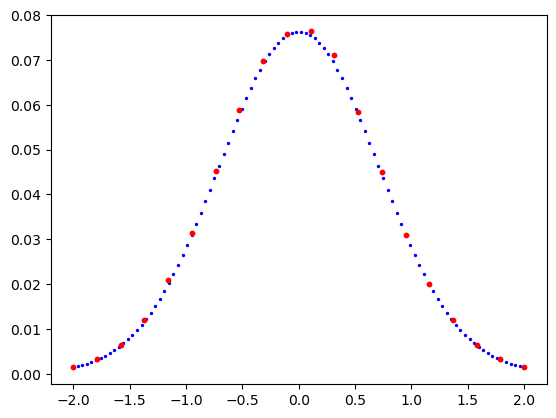

In [7]:
plt.scatter(x_exact, propagators_exact, s=2, color='blue')
plt.scatter(x_pimc, propagators_pimc, s=10, color='red')
plt.show()

In [8]:
for result in propagators_pimc_results:
    print(result.Q)

0.19455423634571736
0.013030861119790502
0.2594459539165847
0.007730962440622066
0.43053563467126277
0.04336109829908284
0.5102635404934257
0.5710838227768809
0.4529229823133596
0.07339665318818621
0.05656780337528404
0.9649493992589739
0.8357920629302612
0.3381405115544338
0.8075120508529391
0.00026403594596246735
0.19049427602395475
0.3666979622724905
0.6505696091420887
0.605122690655018


If all Qs are greater than $0.05$, it means that all points are statistically significant. 

# TODO:
- Output the goodness of the integration procedures
- Compare quantitatively Monte Carlo vs exact

# Potential $x^4/2$

In [4]:
def V_x4(x: float):
    return x ** 4 / 2

In [5]:
x4_system = NonRelativisticSingleParticle1D(V=V_x4, T=4, N=8)

In [6]:
propagators_exact = x4_system.compute_propagator_from_ground_state(x_exact)
propagators_pimc_results = x4_system.compute_propagator_pimc(x_pimc, lower_bound=-4, upper_bound=4, neval=10000)
propagators_pimc = np.array([ p.mean for p in propagators_pimc_results ])

Computing...
Took 0.09851980209350586


In [7]:
for result in propagators_pimc_results:
    print(result.Q)

0.9167101151543487
0.5268805486786661
0.8074706964630225
0.28805699833979226
0.4075249973805182
0.9509153021189758
0.33288717790815053
0.5002854082478401
0.39695803645552885
0.3883601095606549
0.34158291803621177
0.5264235331046778
0.048631225088310734
0.5588668639585981
0.809560416227618
0.8831238472583817
0.4391885350805075
0.13913284968790984
0.14001333328290455
0.17256393939007664


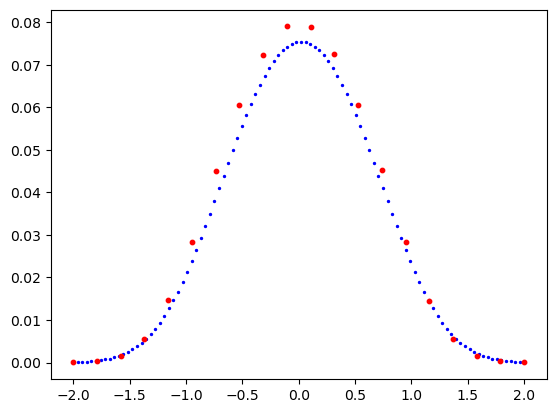

In [8]:
plt.scatter(x_exact, propagators_exact, s=2, color='blue')
plt.scatter(x_pimc, propagators_pimc, s=10, color='red')
plt.show()